<a href="https://colab.research.google.com/github/sathvikb007/ECG_Classification_Ensemble/blob/ensemble/HeartECGNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PS. Wanted to try out a simple soft linear ensemble of different popular image classification architectures. Each model gives the probability of the image belonging to class 1. The ensemble takes weight of all these probabilities and outputs a final probability. EfficientNet B2 gives the best individual score on the test set and the linear blend an even better score

EfficientNet B2 

> Log Loss: 0.5707 

> ROC     : 0.7695 

Linear Ensemble 

> Log Loss: 0.5685


> ROC     : 0.7979

# Loading Data

In [ ]:
#Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
import sys
import time
import math

In [ ]:
#Loading dataset and labels from .npy files

X = np.load("/content/gdrive/MyDrive/HeartECG/physionet_scheme1_x.npy")
y = np.load("/content/gdrive/MyDrive/HeartECG/physionet_scheme1_y.npy")
print(X.shape, y.shape)

(1093, 128, 128, 3) (1093,)


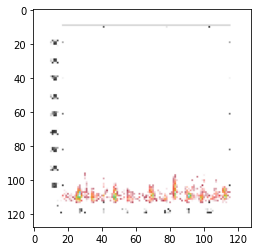

In [ ]:
#Plot a sample image
plt.imshow(X[69])

# Preprocessing Images


In [ ]:
# Split data into train and test ratio of 4:1

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(874, 128, 128, 3) (874,) (219, 128, 128, 3) (219,)


In [ ]:
# Scaling features to be in [0,1] range

X_train = X_train / 255
X_test = X_test / 255

In [ ]:
input_shape = X_test.shape[1:]
num_classes = np.unique(y_test).shape[0]

In [ ]:
# Data augmentation as number of images is fairly less
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  zoom_range = 0.1,
                  shear_range = 0.05
                  )


In [ ]:
tf.keras.backend.clear_session()

# Defining deep learning model functions

In [ ]:
def fit_model(model, epochs, batch_size, output_dir, callbacks, data_augmentation, X_train, y_train, X_test, y_test):
  """
  Fits Keras model with the parameters and callbacks passed
  """
  tf.keras.backend.clear_session()

  model.fit(data_augmentation.flow(X_train, y_train, batch_size=batch_size),
            epochs = epochs,
            validation_data = (X_test, y_test),
            callbacks = callbacks)


In [ ]:
def get_predictions(model, weights_path, X_train, X_test):
  """
  Loads the best weights of the Keras model passed and returns predictions

  Arguments:
    model        : Keras model 
    weights_path : path at which best weights are stored
    X_train      : training set
    X_test       : test set

  Returns:
    ypredtrain   : predictions on training set
    ypredtest    : predictions on test set
  """


  model.load_weights(weights_path)  #Load best resulting weights

  ypredtrain = model.predict(X_train, verbose = 1).reshape(-1,)  #Get predictions for training set
  ypredtest = model.predict(X_test, verbose = 1).reshape(-1,)    #Get predictions for test set  

  train_path = os.path.join(os.getcwd(), "train_predictions", model.name + "_train.csv")  
  test_path = os.path.join(os.getcwd(), "test_predictions", model.name + "_test.csv")     

  pd.Series(ypredtrain).to_csv(train_path)  #Save training predictions
  pd.Series(ypredtest).to_csv(test_path)    #Save test predictions

  return ypredtrain, ypredtest

SyntaxError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

def get_metrics(y_train, ytrainpreds, y_test, ytestpreds):
  """
  Prints the binary crossentropy(log loss) and ROC score 
  for the training and test predictions

  Arguments:
    y_train     : actual training set labels
    ytrainpreds : predictions on training set
    y_test      : actual test set labels
    ytestpreds  : predictions on test set
  """

  #log loss
  logloss_train  = log_loss(y_train, ytrainpreds)
  logloss_test = log_loss(y_test, ytestpreds)
  
  #Area under ROC curve
  roc_train = roc_auc_score(y_train, ytrainpreds)
  roc_test = roc_auc_score(y_test, ytestpreds)

  print(f"Train Log Loss = {logloss_train}, Test Log Loss = {logloss_test}")
  print(f"Train ROC = {roc_train}, Test ROC = {roc_test}")

# Deep Learning Models on Images

## ResNet50V2

In [ ]:
def build_resnet50_model(input_shape, num_classes): #build resnet model

  inputs = tf.keras.layers.Input(shape=input_shape)

  resnet50v2 = tf.keras.applications.ResNet50V2(
      include_top=False,
      input_shape = input_shape,
      weights="imagenet",
      input_tensor=inputs,
  )

  # Freeze the pretrained weights
  resnet50v2.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(resnet50v2.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="ResNet50V2")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['accuracy', 'AUC'])

  model.summary()
  return model

In [ ]:
resnet50v2 = build_resnet50_model(input_shape, num_classes)

94674944/94668760 [==============================] - 0s 0us/step
Model: "ResNet50V2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
________________________

In [ ]:
fit_model(resnet50v2, 100, 64, 'resnet50v2.h5', data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/100
lrate = 0.01
14/14 [==============================] - 10s 430ms/step - loss: 0.8534 - accuracy: 0.5230 - auc: 0.5324 - val_loss: 5.5718 - val_accuracy: 0.5479 - val_auc: 0.5000
Epoch 2/100
lrate = 0.01
14/14 [==============================] - 5s 336ms/step - loss: 0.7593 - accuracy: 0.6122 - auc: 0.6293 - val_loss: 8.9529 - val_accuracy: 0.4521 - val_auc: 0.5000
Epoch 3/100
lrate = 0.01
14/14 [==============================] - 5s 334ms/step - loss: 0.7843 - accuracy: 0.6023 - auc: 0.6317 - val_loss: 9.6636 - val_accuracy: 0.4521 - val_auc: 0.5000
Epoch 4/100
lrate = 0.01
14/14 [==============================] - 5s 343ms/step - loss: 0.7144 - accuracy: 0.6380 - auc: 0.6738 - val_loss: 1.2445 - val_accuracy: 0.4384 - val_auc: 0.6372
Epoch 5/100
lrate = 0.01
14/14 [==============================] - 5s 334ms/step - loss: 0.7239 - accuracy: 0.6198 - auc: 0.6516 - val_loss: 1.3899 - val_accuracy: 0.5479 - val_auc: 0.6242
Epoch 6/100
lrate = 0.01
14/14 [===========================

In [ ]:
resnet50v2_train_preds, resnet50v2_test_preds = get_predictions(resnet50v2, "resnet50v2.h5", X_train, X_test)

7/7 [==============================] - 0s 77ms/step


In [ ]:
get_metrics(y_train, resnet50v2_train_preds, y_test, resnet50v2_test_preds)

Train Log Loss = 0.6336089942851519, Test Log Loss = 0.6269316686546966
Train ROC = 0.6874175286255481, Test ROC = 0.6991582491582492


## Xception

In [ ]:
def build_xception_model(input_shape, weights_path): #build XCeption model

  inputs = tf.keras.layers.Input(shape=input_shape)

  xception = tf.keras.applications.Xception(
      include_top=False,
      input_shape = input_shape,
      weights="imagenet",
      input_tensor=inputs,
  )

  # Freeze the pretrained weights
  xception.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(xception.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="Xception")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [lr_scheduler, model_checkpoint, reduce_lr]

  model.summary()
  return model, callbacks

In [ ]:
xception, xception_callbacks  = build_xception_model(input_shape, "Xception.h5")

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
fit_model(xception, 500, 64, 'Xception.h5', xception_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/500
lrate = 0.001
14/14 [==============================] - 11s 454ms/step - loss: 0.7389 - accuracy: 0.5449 - auc: 0.5459 - val_loss: 0.6987 - val_accuracy: 0.6621 - val_auc: 0.6696
Epoch 2/500
lrate = 0.001
14/14 [==============================] - 5s 367ms/step - loss: 0.7394 - accuracy: 0.5530 - auc: 0.5330 - val_loss: 1.2477 - val_accuracy: 0.5479 - val_auc: 0.6801
Epoch 3/500
lrate = 0.001
14/14 [==============================] - 5s 357ms/step - loss: 0.7113 - accuracy: 0.5764 - auc: 0.5691 - val_loss: 0.7960 - val_accuracy: 0.5662 - val_auc: 0.6963
Epoch 4/500
lrate = 0.001
14/14 [==============================] - 5s 362ms/step - loss: 0.7016 - accuracy: 0.5921 - auc: 0.5947 - val_loss: 0.6608 - val_accuracy: 0.6119 - val_auc: 0.6937
Epoch 5/500
lrate = 0.001
14/14 [==============================] - 5s 361ms/step - loss: 0.7132 - accuracy: 0.5799 - auc: 0.5878 - val_loss: 1.1713 - val_accuracy: 0.5479 - val_auc: 0.7084
Epoch 6/500
lrate = 0.001
14/14 [=====================

KeyboardInterrupt: ignored

In [ ]:
xception_train_preds, xception_test_preds = get_predictions(xception, "Xception.h5", X_train, X_test)

7/7 [==============================] - 1s 96ms/step


In [ ]:
get_metrics(y_train, xception_train_preds, y_test, xception_test_preds)

Train Log Loss = 0.6268898583692871, Test Log Loss = 0.6313991492367499
Train ROC = 0.7146756480653812, Test ROC = 0.7072390572390573


## Inception ResNet V2

In [ ]:
def build_inceptionresnetv2_model(input_shape, weights_path): #build XCeption model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)

  inception = tf.keras.applications.InceptionResNetV2(
      include_top=False,
      input_shape = input_shape,
      weights="imagenet",
      input_tensor=inputs,
  )

  # Freeze the pretrained weights
  inception.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(inception.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="InceptionResnetV2")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
inception_resnet, inception_resnet_callbacks  = build_inceptionresnetv2_model(input_shape, "InceptionResnetV2.h5")

In [ ]:
fit_model(inception_resnet, 150, 64, 'InceptionResnetV2.h5', inception_resnet_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 23s 713ms/step - loss: 0.9714 - accuracy: 0.5042 - auc: 0.4983 - val_loss: 1.8099 - val_accuracy: 0.5479 - val_auc: 0.6814
Epoch 2/150
14/14 [==============================] - 6s 426ms/step - loss: 0.8149 - accuracy: 0.4792 - auc: 0.5074 - val_loss: 2.1314 - val_accuracy: 0.5479 - val_auc: 0.6713
Epoch 3/150
14/14 [==============================] - 6s 442ms/step - loss: 0.7753 - accuracy: 0.5297 - auc: 0.5483 - val_loss: 1.2141 - val_accuracy: 0.5479 - val_auc: 0.6713
Epoch 4/150
14/14 [==============================] - 6s 415ms/step - loss: 0.7701 - accuracy: 0.5130 - auc: 0.5187 - val_loss: 0.8073 - val_accuracy: 0.5434 - val_auc: 0.6955
Epoch 5/150
14/14 [==============================] - 6s 415ms/step - loss: 0.7915 - accuracy: 0.4802 - auc: 0.4825 - val_loss: 0.8143 - val_accuracy: 0.5434 - val_auc: 0.7004
Epoch 6/150
14/14 [==============================] - 6s 418ms/step - loss: 0.7427 - accuracy: 0.5427 - auc: 0.5325 - val_los

In [ ]:
inception_resnet_train_preds, inception_resnet_test_preds = get_predictions(inception_resnet, "InceptionResnetV2.h5", X_train, X_test)

7/7 [==============================] - 1s 164ms/step


In [ ]:
get_metrics(y_train, inception_resnet_train_preds, y_test, inception_resnet_test_preds)

Train Log Loss = 0.6766143044631596, Test Log Loss = 0.6737628775100185
Train ROC = 0.6386370408206701, Test ROC = 0.6982323232323232


## DenseNet 201

In [ ]:
def build_densenet201_model(input_shape, weights_path): #build DenseNet201 model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)

  densenet = tf.keras.applications.DenseNet201(
      include_top=False,
      input_shape = input_shape,
      weights="imagenet",
      input_tensor=inputs,
  )

  # Freeze the pretrained weights
  densenet.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(densenet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="DenseNet201")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
densenet201, densenet201_callbacks  = build_densenet201_model(input_shape, "DenseNet201.h5")

74842112/74836368 [==============================] - 1s 0us/step
Model: "DenseNet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_______________________

In [ ]:
fit_model(densenet201, 150, 64, 'DenseNet201.h5', densenet201_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 57s 964ms/step - loss: 0.7459 - accuracy: 0.5548 - auc: 0.5694 - val_loss: 0.8418 - val_accuracy: 0.4566 - val_auc: 0.6555
Epoch 2/150
14/14 [==============================] - 4s 272ms/step - loss: 0.7187 - accuracy: 0.5608 - auc: 0.5668 - val_loss: 0.6936 - val_accuracy: 0.6256 - val_auc: 0.6809
Epoch 3/150
14/14 [==============================] - 4s 274ms/step - loss: 0.7024 - accuracy: 0.5765 - auc: 0.5862 - val_loss: 0.7074 - val_accuracy: 0.6393 - val_auc: 0.6782
Epoch 4/150
14/14 [==============================] - 4s 268ms/step - loss: 0.6806 - accuracy: 0.6059 - auc: 0.6316 - val_loss: 0.7018 - val_accuracy: 0.6301 - val_auc: 0.6934
Epoch 5/150
14/14 [==============================] - 4s 285ms/step - loss: 0.6645 - accuracy: 0.6131 - auc: 0.6338 - val_loss: 0.7075 - val_accuracy: 0.6301 - val_auc: 0.6963
Epoch 6/150
14/14 [==============================] - 4s 271ms/step - loss: 0.6743 - accuracy: 0.6233 - auc: 0.6361 - val_los

In [ ]:
densenet201_train_preds, densenet201_test_preds = get_predictions(densenet201, "DenseNet201.h5", X_train, X_test)

7/7 [==============================] - 0s 60ms/step


In [ ]:
get_metrics(y_train, densenet201_train_preds, y_test, densenet201_test_preds)

Train Log Loss = 0.6136840081439487, Test Log Loss = 0.626884048626031
Train ROC = 0.7399172093815178, Test ROC = 0.7279461279461278


## EfficientNet B0

In [ ]:
def build_efficientnetb0(input_shape, weights_path): #build EfficientNetB0 model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)
  #preprocessed_inputs = tf.keras.applications.efficientnet.preprocess_input(inputs)

  effnet = tf.keras.applications.EfficientNetB0(
      include_top=False,
      weights="imagenet",
      input_tensor=inputs,
      input_shape = input_shape
  )

  # Freeze the pretrained weights
  effnet.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
effnetb0, effnetb0_callbacks  = build_efficientnetb0(input_shape, "EfficientNetB0.h5")

16711680/16705208 [==============================] - 0s 0us/step
Model: "EfficientNetB0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
____________________

In [ ]:
fit_model(effnetb0, 150, 64, 'EfficientNetB0.h5', effnetb0_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 10s 338ms/step - loss: 0.8368 - accuracy: 0.5450 - auc: 0.5360 - val_loss: 0.6643 - val_accuracy: 0.6849 - val_auc: 0.7206
Epoch 2/150
14/14 [==============================] - 3s 233ms/step - loss: 0.6996 - accuracy: 0.6346 - auc: 0.6838 - val_loss: 0.6546 - val_accuracy: 0.6849 - val_auc: 0.7450
Epoch 3/150
14/14 [==============================] - 3s 235ms/step - loss: 0.7201 - accuracy: 0.6102 - auc: 0.6453 - val_loss: 0.6573 - val_accuracy: 0.6849 - val_auc: 0.7543
Epoch 4/150
14/14 [==============================] - 3s 232ms/step - loss: 0.6679 - accuracy: 0.6518 - auc: 0.6899 - val_loss: 0.6708 - val_accuracy: 0.5936 - val_auc: 0.7495
Epoch 5/150
14/14 [==============================] - 3s 229ms/step - loss: 0.6440 - accuracy: 0.6691 - auc: 0.7027 - val_loss: 0.6622 - val_accuracy: 0.6530 - val_auc: 0.7439
Epoch 6/150
14/14 [==============================] - 3s 226ms/step - loss: 0.6418 - accuracy: 0.6610 - auc: 0.7001 - val_los

In [ ]:
effnetb0_train_preds, effnetb0_test_preds = get_predictions(effnetb0, "EfficientNetB0.h5", X_train, X_test)

7/7 [==============================] - 0s 22ms/step


In [ ]:
get_metrics(y_train, effnetb0_train_preds, y_test, effnetb0_test_preds)

Train Log Loss = 0.547812263919275, Test Log Loss = 0.5831398553635976
Train ROC = 0.7906397650363938, Test ROC = 0.7634680134680135


## EfficientNet B1

In [ ]:
def build_efficientnetb1(input_shape, weights_path): #build EfficientNetB1 model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)
  #preprocessed_inputs = tf.keras.applications.efficientnet.preprocess_input(inputs)

  effnet = tf.keras.applications.EfficientNetB1(
      include_top=False,
      weights="imagenet",
      input_tensor=inputs,
      input_shape = input_shape
  )

  # Freeze the pretrained weights
  effnet.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNetB1")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
effnetb1, effnetb1_callbacks  = build_efficientnetb1(input_shape, "EfficientNetB1.h5")

In [ ]:
fit_model(effnetb1, 150, 64, 'EfficientNetB1.h5', effnetb1_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 15s 491ms/step - loss: 0.8881 - accuracy: 0.5027 - auc: 0.4985 - val_loss: 0.6967 - val_accuracy: 0.5023 - val_auc: 0.6737
Epoch 2/150
14/14 [==============================] - 3s 247ms/step - loss: 0.6765 - accuracy: 0.6288 - auc: 0.6773 - val_loss: 0.6674 - val_accuracy: 0.6027 - val_auc: 0.7114
Epoch 3/150
14/14 [==============================] - 3s 245ms/step - loss: 0.7022 - accuracy: 0.6508 - auc: 0.6755 - val_loss: 0.6449 - val_accuracy: 0.6804 - val_auc: 0.7306
Epoch 4/150
14/14 [==============================] - 3s 248ms/step - loss: 0.6741 - accuracy: 0.6706 - auc: 0.6965 - val_loss: 0.6406 - val_accuracy: 0.6849 - val_auc: 0.7404
Epoch 5/150
14/14 [==============================] - 3s 247ms/step - loss: 0.6499 - accuracy: 0.6718 - auc: 0.7196 - val_loss: 0.6361 - val_accuracy: 0.7032 - val_auc: 0.7505
Epoch 6/150
14/14 [==============================] - 3s 244ms/step - loss: 0.6454 - accuracy: 0.6566 - auc: 0.7089 - val_los

In [ ]:
effnetb1_train_preds, effnetb1_test_preds = get_predictions(effnetb1, "EfficientNetB1.h5", X_train, X_test)

7/7 [==============================] - 0s 32ms/step


In [ ]:
get_metrics(y_train, effnetb1_train_preds, y_test, effnetb1_test_preds)

Train Log Loss = 0.5556051750034435, Test Log Loss = 0.5817077994074451
Train ROC = 0.7825309666709233, Test ROC = 0.7571548821548822




## EfficientNet B2

In [ ]:
def build_efficientnetb2(input_shape, weights_path): #build EfficientNetB2 model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)
  #preprocessed_inputs = tf.keras.applications.efficientnet.preprocess_input(inputs)

  effnet = tf.keras.applications.EfficientNetB2(
      include_top=False,
      weights="imagenet",
      input_tensor=inputs,
      input_shape = input_shape
  )

  # Freeze the pretrained weights
  effnet.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNetB2")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
effnetb2, effnetb2_callbacks  = build_efficientnetb2(input_shape, "EfficientNetB2.h5")

In [ ]:
fit_model(effnetb2, 150, 64, 'EfficientNetB2.h5', effnetb2_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 15s 464ms/step - loss: 0.9681 - accuracy: 0.4871 - auc: 0.4853 - val_loss: 0.6742 - val_accuracy: 0.5479 - val_auc: 0.6915
Epoch 2/150
14/14 [==============================] - 3s 242ms/step - loss: 0.7270 - accuracy: 0.6108 - auc: 0.6422 - val_loss: 0.6597 - val_accuracy: 0.5434 - val_auc: 0.7109
Epoch 3/150
14/14 [==============================] - 4s 250ms/step - loss: 0.7028 - accuracy: 0.6289 - auc: 0.6643 - val_loss: 0.6466 - val_accuracy: 0.6027 - val_auc: 0.7247
Epoch 4/150
14/14 [==============================] - 3s 244ms/step - loss: 0.7247 - accuracy: 0.6515 - auc: 0.6652 - val_loss: 0.6595 - val_accuracy: 0.5525 - val_auc: 0.7132
Epoch 5/150
14/14 [==============================] - 3s 248ms/step - loss: 0.6961 - accuracy: 0.6234 - auc: 0.6638 - val_loss: 0.6501 - val_accuracy: 0.5434 - val_auc: 0.7145
Epoch 6/150
14/14 [==============================] - 3s 240ms/step - loss: 0.6466 - accuracy: 0.6488 - auc: 0.7115 - val_los

In [ ]:
effnetb2_train_preds, effnetb2_test_preds = get_predictions(effnetb2, "EfficientNetB2.h5", X_train, X_test)

7/7 [==============================] - 0s 32ms/step


In [ ]:
get_metrics(y_train, effnetb2_train_preds, y_test, effnetb2_test_preds)

Train Log Loss = 0.5457510009910954, Test Log Loss = 0.5707821393870327
Train ROC = 0.7924381730728302, Test ROC = 0.7695286195286195


## EfficientNet B3

In [ ]:
def build_efficientnetb3(input_shape, weights_path): #build EfficientNetB3 model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)
  #preprocessed_inputs = tf.keras.applications.efficientnet.preprocess_input(inputs)

  effnet = tf.keras.applications.EfficientNetB3(
      include_top=False,
      weights="imagenet",
      input_tensor=inputs,
      input_shape = input_shape
  )

  # Freeze the pretrained weights
  effnet.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNetB3")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
effnetb3, effnetb3_callbacks  = build_efficientnetb3(input_shape, "EfficientNetB3.h5")

In [ ]:
fit_model(effnetb3, 150, 64, 'EfficientNetB3.h5', effnetb3_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 17s 530ms/step - loss: 0.8097 - accuracy: 0.5667 - auc: 0.5710 - val_loss: 0.6434 - val_accuracy: 0.6438 - val_auc: 0.7220
Epoch 2/150
14/14 [==============================] - 4s 257ms/step - loss: 0.7005 - accuracy: 0.6431 - auc: 0.6720 - val_loss: 0.6390 - val_accuracy: 0.6438 - val_auc: 0.7291
Epoch 3/150
14/14 [==============================] - 4s 252ms/step - loss: 0.7116 - accuracy: 0.6386 - auc: 0.6583 - val_loss: 0.6452 - val_accuracy: 0.5890 - val_auc: 0.7309
Epoch 4/150
14/14 [==============================] - 4s 251ms/step - loss: 0.6710 - accuracy: 0.6562 - auc: 0.7002 - val_loss: 0.6382 - val_accuracy: 0.5982 - val_auc: 0.7339
Epoch 5/150
14/14 [==============================] - 4s 255ms/step - loss: 0.6738 - accuracy: 0.6693 - auc: 0.7127 - val_loss: 0.6374 - val_accuracy: 0.5982 - val_auc: 0.7354
Epoch 6/150
14/14 [==============================] - 4s 252ms/step - loss: 0.6673 - accuracy: 0.6571 - auc: 0.6951 - val_los

In [ ]:
effnetb3_train_preds, effnetb3_test_preds = get_predictions(effnetb3, "EfficientNetB3.h5", X_train, X_test)

7/7 [==============================] - 0s 45ms/step


In [ ]:
get_metrics(y_train, effnetb3_train_preds, y_test, effnetb3_test_preds)

Train Log Loss = 0.5593178232117328, Test Log Loss = 0.5880160644378292
Train ROC = 0.7833131145447579, Test ROC = 0.7517676767676769


## EfficientNet B4

In [ ]:
def build_efficientnetb4(input_shape, weights_path): #build EfficientNetB4 model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)
  #preprocessed_inputs = tf.keras.applications.efficientnet.preprocess_input(inputs)

  effnet = tf.keras.applications.EfficientNetB4(
      include_top=False,
      weights="imagenet",
      input_tensor=inputs,
      input_shape = input_shape
  )

  # Freeze the pretrained weights
  effnet.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNetB4")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
effnetb4, effnetb4_callbacks  = build_efficientnetb4(input_shape, "EfficientNetB4.h5")

In [ ]:
fit_model(effnetb4, 150, 64, 'EfficientNetB4.h5', effnetb4_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 18s 594ms/step - loss: 0.8249 - accuracy: 0.5385 - auc: 0.5432 - val_loss: 0.6602 - val_accuracy: 0.6393 - val_auc: 0.6762
Epoch 2/150
14/14 [==============================] - 4s 269ms/step - loss: 0.7117 - accuracy: 0.6331 - auc: 0.6650 - val_loss: 0.6718 - val_accuracy: 0.5525 - val_auc: 0.6825
Epoch 3/150
14/14 [==============================] - 4s 269ms/step - loss: 0.6751 - accuracy: 0.6385 - auc: 0.6940 - val_loss: 0.6589 - val_accuracy: 0.6301 - val_auc: 0.6878
Epoch 4/150
14/14 [==============================] - 4s 273ms/step - loss: 0.6932 - accuracy: 0.6474 - auc: 0.6811 - val_loss: 0.6718 - val_accuracy: 0.5479 - val_auc: 0.7061
Epoch 5/150
14/14 [==============================] - 4s 288ms/step - loss: 0.6861 - accuracy: 0.6378 - auc: 0.6730 - val_loss: 0.6617 - val_accuracy: 0.5616 - val_auc: 0.7023
Epoch 6/150
14/14 [==============================] - 4s 269ms/step - loss: 0.6905 - accuracy: 0.6444 - auc: 0.6666 - val_los

In [ ]:
effnetb4_train_preds, effnetb4_test_preds = get_predictions(effnetb4, "EfficientNetB4.h5", X_train, X_test)

7/7 [==============================] - 0s 58ms/step


In [ ]:
get_metrics(y_train, effnetb4_train_preds, y_test, effnetb4_test_preds)

Train Log Loss = 0.5616199131586186, Test Log Loss = 0.5944744449568121
Train ROC = 0.7794928276507895, Test ROC = 0.748905723905724


## EfficientNet B5

In [ ]:
def build_efficientnetb5(input_shape, weights_path): #build EfficientNetB5 model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)
  #preprocessed_inputs = tf.keras.applications.efficientnet.preprocess_input(inputs)

  effnet = tf.keras.applications.EfficientNetB5(
      include_top=False,
      weights="imagenet",
      input_tensor=inputs,
      input_shape = input_shape
  )

  # Freeze the pretrained weights
  effnet.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNetB5")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
effnetb5, effnetb5_callbacks  = build_efficientnetb5(input_shape, "EfficientNetB5.h5")

In [ ]:
fit_model(effnetb5, 150, 64, 'EfficientNetB5.h5', effnetb5_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 22s 692ms/step - loss: 0.9326 - accuracy: 0.5075 - auc: 0.5058 - val_loss: 0.7105 - val_accuracy: 0.4566 - val_auc: 0.6042
Epoch 2/150
14/14 [==============================] - 4s 298ms/step - loss: 0.7361 - accuracy: 0.6210 - auc: 0.6373 - val_loss: 0.6751 - val_accuracy: 0.6119 - val_auc: 0.6659
Epoch 3/150
14/14 [==============================] - 4s 302ms/step - loss: 0.7494 - accuracy: 0.5817 - auc: 0.6058 - val_loss: 0.6720 - val_accuracy: 0.6667 - val_auc: 0.7109
Epoch 4/150
14/14 [==============================] - 4s 300ms/step - loss: 0.6932 - accuracy: 0.6204 - auc: 0.6551 - val_loss: 0.6746 - val_accuracy: 0.6575 - val_auc: 0.6836
Epoch 5/150
14/14 [==============================] - 5s 321ms/step - loss: 0.6843 - accuracy: 0.6292 - auc: 0.6667 - val_loss: 0.6786 - val_accuracy: 0.6667 - val_auc: 0.6480
Epoch 6/150
14/14 [==============================] - 4s 301ms/step - loss: 0.7056 - accuracy: 0.6174 - auc: 0.6555 - val_los

In [ ]:
effnetb5_train_preds, effnetb5_test_preds = get_predictions(effnetb5, "EfficientNetB5.h5", X_train, X_test)

7/7 [==============================] - 1s 81ms/step


In [ ]:
get_metrics(y_train, effnetb5_train_preds, y_test, effnetb5_test_preds)

Train Log Loss = 0.5581591753225168, Test Log Loss = 0.60150609719971
Train ROC = 0.7860373302685906, Test ROC = 0.7388047138047138


## EfficientNet B6

In [ ]:
def build_efficientnetb6(input_shape, weights_path): #build EfficientNetB6 model
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=input_shape)
  #preprocessed_inputs = tf.keras.applications.efficientnet.preprocess_input(inputs)

  effnet = tf.keras.applications.EfficientNetB6(
      include_top=False,
      weights="imagenet",
      input_tensor=inputs,
      input_shape = input_shape
  )

  # Freeze the pretrained weights
  effnet.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.25, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNetB6")
                          
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'AUC'])
  
  # Reduce learning rate when loss reaches a plateau
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                                      min_lr=0.0001, verbose = 1)
  
  # Learning Rate Scheduler - decay after 10 epochs
  def scheduler(epoch, lr):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("lrate = " + str(lrate))
    return lrate

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

  # Checkpoint to save best weights
  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path, monitor = 'val_loss', save_best_only=True)

  callbacks = [model_checkpoint]

  model.summary()
  return model, callbacks

In [ ]:
effnetb6weights  = 'EfficientNetB6.h5'

In [ ]:
effnetb6, effnetb6_callbacks  = build_efficientnetb6(input_shape, effnetb6weights)

In [ ]:
fit_model(effnetb6, 150, 64, effnetb6weights, effnetb6_callbacks, data_augmentation, X_train, y_train, X_test, y_test)

Epoch 1/150
14/14 [==============================] - 25s 767ms/step - loss: 0.7814 - accuracy: 0.5542 - auc: 0.5530 - val_loss: 0.7331 - val_accuracy: 0.5479 - val_auc: 0.6902
Epoch 2/150
14/14 [==============================] - 5s 332ms/step - loss: 0.7152 - accuracy: 0.5915 - auc: 0.6138 - val_loss: 0.6661 - val_accuracy: 0.5525 - val_auc: 0.7077
Epoch 3/150
14/14 [==============================] - 5s 329ms/step - loss: 0.7038 - accuracy: 0.6483 - auc: 0.6718 - val_loss: 0.6801 - val_accuracy: 0.5479 - val_auc: 0.7153
Epoch 4/150
14/14 [==============================] - 5s 357ms/step - loss: 0.6903 - accuracy: 0.6415 - auc: 0.6554 - val_loss: 0.6596 - val_accuracy: 0.5525 - val_auc: 0.7210
Epoch 5/150
14/14 [==============================] - 5s 331ms/step - loss: 0.6797 - accuracy: 0.6329 - auc: 0.6900 - val_loss: 0.6502 - val_accuracy: 0.6027 - val_auc: 0.7176
Epoch 6/150
14/14 [==============================] - 5s 338ms/step - loss: 0.7011 - accuracy: 0.6416 - auc: 0.6808 - val_los

In [ ]:
effnetb6_train_preds, effnetb6_test_preds = get_predictions(effnetb6, effnetb6weights, X_train, X_test)

7/7 [==============================] - 1s 105ms/step


In [ ]:
get_metrics(y_train, effnetb6_train_preds, y_test, effnetb6_test_preds)

Train Log Loss = 0.585966418678414, Test Log Loss = 0.5954659138232061
Train ROC = 0.7481164602221938, Test ROC = 0.7479797979797981


# Linear Blending

We combine the model predictions using simple Lasso Regression (Linear Regression with L1 regularization). Lasso regression is a good fit here since the L1 regularization naturally acts as a feature selector

In [ ]:
# Load models' predictions into dataframes

train_model_preds = pd.DataFrame()
train_folder = "/content/gdrive/MyDrive/HeartECG/train_predictions"
for train_files in os.listdir(train_folder):
  train_model_preds[train_files.split('.')[0]] = pd.read_csv(os.path.join(train_folder, train_files), engine = 'python', squeeze=True)['0']

test_model_preds = pd.DataFrame()
test_folder = "/content/gdrive/MyDrive/HeartECG/test_predictions"
for test_files in os.listdir(test_folder):
  test_model_preds[test_files.split('.')[0]] = pd.read_csv(os.path.join(test_folder, test_files), squeeze=True)['0']

In [ ]:
train_model_preds

,ResNet50V2_train,Xception_train,InceptionResnetV2_train,EfficientNetB0_train,EfficientNetB2_train,EfficientNetB3_train,EfficientNetB4_train,EfficientNetB5_train,EfficientNetB6_train,DenseNet201_train,EfficientNetB1_train
0,0.741118,0.666470,0.599296,0.687187,0.764961,0.793193,0.739863,0.636933,0.605773,0.821221,0.787219
1,0.346789,0.414661,0.575925,0.272184,0.265838,0.291428,0.206666,0.282585,0.239376,0.319692,0.313189
2,0.757485,0.756505,0.502228,0.599428,0.764640,0.873401,0.542219,0.650290,0.714862,0.809269,0.730281
3,0.326514,0.716924,0.602864,0.273230,0.397821,0.334405,0.443344,0.459433,0.455611,0.405021,0.370262
4,0.475085,0.606299,0.548412,0.571985,0.624104,0.732477,0.819927,0.678253,0.726022,0.598125,0.634831
...,...,...,...,...,...,...,...,...,...,...,...
869,0.313856,0.538970,0.605373,0.241087,0.315817,0.366516,0.421808,0.312215,0.365296,0.321508,0.373081
870,0.451459,0.593510,0.582093,0.201256,0.303956,0.438711,0.308283,0.318038,0.396505,0.587443,0.338054
871,0.338319,0.209875,0.603411,0.217118,0.315689,0.212415,0.152875,0.309167,0.365068,0.406737,0.500958
872,0.772718,0.772965,0.579080,0.854300,0.825213,0.849704,0.790739,0.807444,0.814145,0.780709,0.839909


In [ ]:
test_model_preds

,ResNet50V2_test,Xception_test,InceptionResnetV2_test,EfficientNetB0_test,EfficientNetB2_test,EfficientNetB3_test,EfficientNetB4_test,EfficientNetB5_test,EfficientNetB6_test,DenseNet201_test,EfficientNetB1_test
0,0.365420,0.566484,0.566960,0.246100,0.318784,0.355314,0.337766,0.406727,0.384172,0.509400,0.257480
1,0.785139,0.755221,0.605394,0.871502,0.800857,0.896928,0.846508,0.829222,0.792937,0.785909,0.898645
2,0.349255,0.449544,0.568549,0.354164,0.382822,0.357328,0.279726,0.321021,0.451912,0.518291,0.378676
3,0.214464,0.513736,0.526742,0.366817,0.506783,0.310596,0.196727,0.711252,0.599979,0.545561,0.541270
4,0.787753,0.765016,0.599203,0.865549,0.810217,0.880758,0.915492,0.888079,0.810226,0.787365,0.888498
...,...,...,...,...,...,...,...,...,...,...,...
214,0.387184,0.470886,0.601384,0.576716,0.415780,0.465713,0.535847,0.586551,0.416149,0.421646,0.469357
215,0.454249,0.592360,0.571223,0.528124,0.546926,0.474116,0.520099,0.472608,0.542237,0.457022,0.435732
216,0.371363,0.637040,0.627766,0.814125,0.765458,0.838633,0.772961,0.851709,0.765024,0.669437,0.782632
217,0.357484,0.429804,0.575241,0.265020,0.288230,0.289757,0.376536,0.355684,0.405679,0.508495,0.263517


In [ ]:
from sklearn.linear_model import Lasso  # Lasso Regression on Model Predictions
blender1 = Lasso(alpha = 6.3e-3)
blender1.fit(train_model_preds.iloc[:, :], y_train)
blender1_trainpreds = blender1.predict(train_model_preds.iloc[:, :]).reshape(-1,)
blender1_testpreds = blender1.predict(test_model_preds.iloc[:, :]).reshape(-1,)
get_metrics(y_train, blender1_trainpreds, y_test, blender1_testpreds)

Train Log Loss = 0.5412094034455456, Test Log Loss = 0.5685370050429107
Train ROC = 0.797907887455838, Test ROC = 0.7796296296296297
